In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import torch
from module.cell_classifier import CellClassifier
import scanpy as sc
from tools.analysis import predict_slide
from tools.basics import load_model

/home/luca/anaconda3/envs/plugin-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
adata_name = 'CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma'
data_path = f'../data/{adata_name}/'
json_path = data_path + 'seg_json/pannuke_fast_mask_lvl3.json'
image_path = data_path + 'CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma_tissue_image.tif'
path_ST_adata = data_path + "ST/"
model_path = '../out/model_bs8_lr1e-3_agglossmean_alpha02_epochs50/best_model.pth'

#load adata
adata = sc.read_visium(path_ST_adata)

#load image dict
image_dict = torch.load(data_path + "images_dict.pt")

#load proportions
proportions_file = data_path + "C2L_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma_prop.csv"
proportions = pd.read_csv(proportions_file, index_col=0)

/home/luca/anaconda3/envs/plugin-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/luca/anaconda3/envs/plugin-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
model = load_model(model_path, num_classes=proportions.shape[1])

Device found to load the model :  cpu


In [5]:
predictions = predict_slide(model, image_dict, batch_size=128)

Device used :  cpu


Predicting on cells: 100%|██████████| 2751/2751 [00:46<00:00, 59.03batch/s]


In [6]:
predictions

{'0': {'predicted_class': 7,
  'probabilities': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   5.06356397486844e-37]},
 '1': {'predicted_class': 7,
  'probabilities': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '2': {'predicted_class': 7,
  'probabilities': [0.0,
   0.0,
   1.2048224066418345e-39,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   9.502465622491922e-25]},
 '3': {'predicted_class': 7,
  'probabilities': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.674411535021724e-41]},
 '4': {'predicted_class': 7,
  'probabilities': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '5': {'predicted_class': 7,
  'probabilities': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '6': {'predicted_class': 7,
  'probabilities': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '7': {'predicted_class': 7,
  'probabilities': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   4.5565102643608174e-35]},
 '8': {'predicted_class': 7,
  'probabilities

In [7]:
from tools.analysis import extract_stats
ct_list = list(proportions.columns)
stats = extract_stats(predictions, ct_list, metric='predicted')
stats

,CT,Min Prob,Max Prob,Median Prob,Mean Prob,Cell Count
Class,,,,,,
0,fibroblast,0.235627,1.0,0.948335,0.891760,39641
1,T cell,0.281956,1.0,0.988347,0.905286,4324
2,mast cell,0.269725,1.0,0.997784,0.927818,9908
3,endothelial cell,0.234755,1.0,0.980209,0.892707,5757
7,cancer cell,0.265786,1.0,1.000000,0.994437,281138
8,monocyte,0.254465,1.0,0.979807,0.879991,11325


In [8]:
from tools.analysis import generate_dicts_viz_pred
import json

with open(json_path) as json_file:
    hovernet_dict = json.load(json_file)

In [8]:
pred_dict, color_dict = generate_dicts_viz_pred(hovernet_dict, predictions, ct_list)

In [9]:
from tools.slide_viz import SlideVisualizer

window = ((21000, 13000), (23000, 15000))
plotter = SlideVisualizer(image_path, 
                        adata = adata, 
                        adata_name = adata_name, 
                        dict_cells = pred_dict, 
                        dict_types_colors = color_dict, 
                        window = window)

TIFFReadDirectory: Warning, Unknown field with tag 33560 (0x8318) encountered.


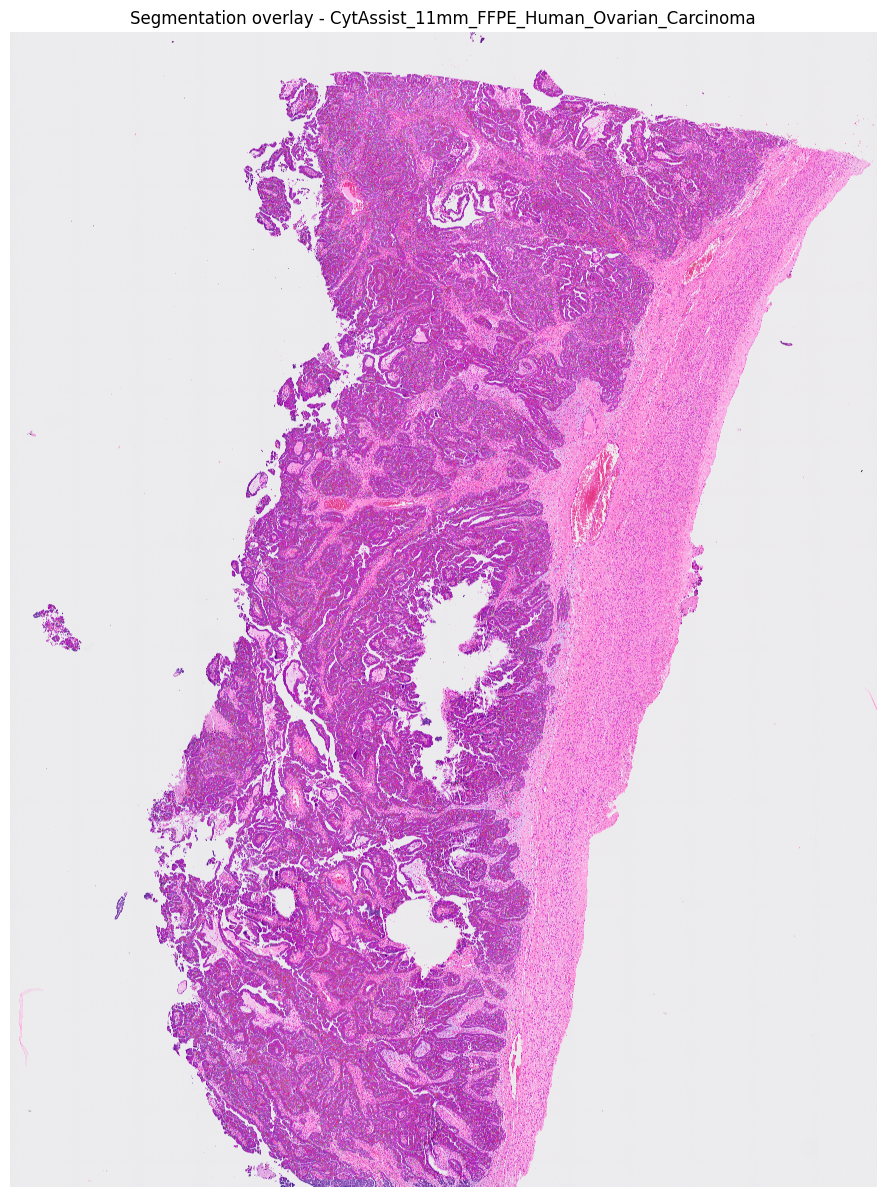

In [139]:
plotter.plot_seg(show_visium=False, draw_dot=False)

# Tests on loss

In [11]:
# def loss_comb_test(outputs, true_proportions, agg = 'mean', alpha=0.5):
        
#     max_prob_loss = - torch.mean(torch.log(outputs.max(dim=1)[0]))
#     if agg == 'mean':
#         pred_proportions = outputs.mean(dim=0)
#     elif agg == 'onehot':
#         predicted_classes = torch.argmax(outputs, dim=1)  # Obtenir les classes prédites
#         one_hot_preds = torch.nn.functional.one_hot(predicted_classes, num_classes=outputs.size(1))
#         pred_proportions = one_hot_preds.float().sum(dim=0) / outputs.size(0)
        
#     divergence_loss = F.mse_loss(pred_proportions, true_proportions)
    
#     # Combined loss
#     loss = alpha * max_prob_loss + (1 - alpha) * divergence_loss
    
#     return loss

In [12]:
# import torch.nn.functional as F
# outputs_t = F.softmax(torch.rand(10, 6), dim=1)
# true_pp_t = F.softmax(torch.rand(6), dim=0)

In [56]:
# outputs_t = torch.tensor([[0.2, 0.1, 0.3, 0.1, 0.2, 0.1],
#         [0.15, 0.2, 0.1, 0.2, 0.3, 0.05],
#         [0.25, 0.1, 0.1, 0.2, 0.05, 0.3],
#         [0.3, 0.2, 0.25, 0.05, 0.1, 0.1],
#         [0.2, 0.2, 0.2, 0.3, 0, 0.1]])

In [14]:
# true_pp_t

In [15]:
# pred_t = torch.nn.functional.one_hot(torch.argmax(outputs_t, dim=1), num_classes=outputs_t.size(1)).float().sum(dim=0) / outputs_t.size(0)
# pred_t

In [16]:
# pred_t = outputs_t.mean(dim=0)
# pred_t

In [17]:
# F.mse_loss(pred_t, true_pp_t)*1e2, - torch.mean(torch.log(outputs_t.max(dim=1)[0]))

# Tests on datasets

In [18]:
# from utils.hovernet_tools import map_cells_to_spots
# from data.load_data import split_data
# spot_dict = map_cells_to_spots(adata, adata_name, json_path)

In [19]:
# from data.load_data import SpotDataset, collate_fn

# train_spot_dict, train_proportions, val_spot_dict, val_proportions, test_spot_dict, test_proportions = split_data(
#         spot_dict, proportions, train_size=0.5, val_size=0.25)
    
# # Create datasets
# train_dataset = SpotDataset(train_spot_dict, train_proportions, image_dict)
# val_dataset = SpotDataset(val_spot_dict, val_proportions, image_dict)
# test_dataset = SpotDataset(test_spot_dict, test_proportions, image_dict)

In [20]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn) #added collate_fn
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn) #added collate_fn
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn) #added collate_fn

In [21]:
# for batch in train_loader:
#     test_images = batch[0][0]
#     test_vector = batch[1][0]
#     break

In [22]:
# test_images.shape

In [23]:
# test_vector

In [24]:
# import numpy as np

# df = proportions.copy()
# df['distance'] = df.apply(lambda row: np.linalg.norm(row.values - test_vector.cpu().numpy()), axis=1)

# # Trouver l'index de la ligne la plus proche
# index_ligne_proche = df['distance'].idxmin()

In [25]:
# proportions.loc[index_ligne_proche]

In [26]:
# len(spot_dict[index_ligne_proche])